In [1]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import utils
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
seq_dict = utils.get_sequence_dict("dataset/NEIS2157.json")

In [3]:
IDs = utils.get_ordered_ids(seq_dict)

points=[]

for id in IDs:
    point = np.array(seq_dict[id]["embedding3"])  # is a (seq_len)*(100) matrix (each row is the embedding of an amminoacid)
    point = np.mean(point, axis=0)  # mean between all amminoacids
    points.append(point)

X = np.array(points)
X.shape

(27, 100)

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [115.0, 115.0, 125.0, 125.0],
  [105.0, 105.0, 120.0, 120.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [215.0, 215.0, 232.5, 232.5],
  [205.0, 205.0, 223.75, 223.75],
  [195.0, 195.0, 214.375, 214.375],
  [255.0, 255.0, 265.0, 265.0],
  [204.6875, 204.6875, 260.0, 260.0],
  [185.0, 185.0, 232.34375, 232.34375],
  [175.0, 175.0, 208.671875, 208.671875],
  [165.0, 165.0, 191.8359375, 191.8359375],
  [155.0, 155.0, 178.41796875, 178.41796875],
  [145.0, 145.0, 166.708984375, 166.708984375],
  [135.0, 135.0, 155.8544921875, 155.8544921875],
  [112.5, 112.5, 145.42724609375, 145.42724609375],
  [95.0, 95.0, 128.963623046875, 128.963623046875],
  [72.5, 72.5, 111.9818115234375, 111.9818115234375],
  [55.0, 55.0, 92.24090576171875, 92.24090576171875],
  [45.0, 45.0, 73.62045288085938, 73.62045288085938],
  [35.0, 35.0, 59.31022644042969, 59.31022644042969],
  [25.0, 25.0, 47.

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


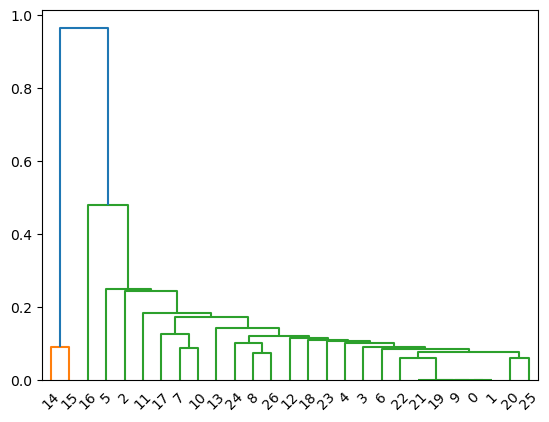

In [5]:
# Perform hierarchical clustering
Z = linkage(X, method='average')

# Plot dendrogram (optional)
dendrogram(Z)

# Get cluster labels
max_d =30  # set the maximum distance between clusters
labels = fcluster(Z, max_d, criterion='distance')

print(labels)

In [21]:
from Bio.Align.Applications import MuscleCommandline
from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor


cline = MuscleCommandline(input="dataset/NEIS2157.fasta", out="dataset/NEIS2157_alignment.fasta")
#cline()


# Read the alignment file in FASTA format
alignment = AlignIO.read("dataset/NEIS2157_alignment.fasta", "fasta")

# Create a distance calculator and calculate the distance matrix
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)

# Build a tree from the distance matrix using the maximum likelihood method
constructor = DistanceTreeConstructor(calculator, 'upgma')
tree = constructor.build_tree(alignment)

# Print the tree in ASCII art format
Phylo.draw_ascii(tree)



                                                             ___ NEIS2157_16
  __________________________________________________________|
 |                                                          |___ NEIS2157_15
 |
 |                                                             , NEIS2157_17
 |                                                             |
 |                                                             , NEIS2157_1
 |                                                             |
 |                                                             | NEIS2157_27
 |                                                             |
 |                                                             | NEIS2157_26
 |                                                             |
 |                                                             | NEIS2157_24
 |                                                             |
_|                                                             | NEIS215